# Predicting the Tony Awards, 2019 (Musicals Only)

Based on my analysis, I predict:
* Hadestown will win Best Original Musical
* Kiss Me, Kate will win Best Revival
* Rachel Chavkin will win Best Director 
* Tootsie will win Best Score
* Santino Fontana will win Best Actor 
* Stephanie J. Block will win Best Actress
* Andre De Shields will win Best Featured Actor 
* Ali Stroker will win Best Featured Actress

Expected number correct by chance:

In [322]:
np.sum(1/tony.loc[(tony.Year==2019)].groupby('Category').count().Year)

1.8666666666666667

Expected number correct by chance, even if I narrow it down to 2 per category:

In [324]:
8/2

4

In [2]:
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl



In [208]:
predictor_award_files = ['bcom.csv','dd.csv','dl.csv','occ.csv','nydcc.csv']
tony_file = 'tony.csv'

In [281]:
tony = pd.read_csv(tony_file,skiprows=0,index_col=False)

In [308]:
tony.head()

,Year,Category,Nominee,Won
0,2000,Actor,Brian Stokes Mitchell,1.0
1,2000,Actress,Heather Headley,1.0
2,2000,Director,Michael Blakemore,1.0
3,2000,FeaturedActor,Boyd Gaines,1.0
4,2000,FeaturedActress,Karen Ziemba,1.0


In [312]:
awards = []
for f in predictor_award_files:
    df = pd.read_csv(f,skiprows=0,index_col=False)
    awards.append(df)
pretonys = pd.concat(awards,axis=0,sort=True)

pretonys.loc[pretonys.Category=='Music','Category'] = 'Score'
pretonys = pretonys.replace(['Andrew R. Butler','Joe Iconis','Peter Mills','Mark Sonnenblick','Shaina Taub','David Yazbek'],['Rags Parkland Sings the Songs of the Future','Be More Chill','The Hello Girls','Midnight at the never Get','Twelfth Night','Tootsie'])


In [216]:
pretonys.pivot_table(index='Award',columns='Category',values='Tony',aggfunc=np.nanmean)

Category,Actor,Actress,Director,FeaturedActor,FeaturedActress,Musical,Revival,Score
Award,,,,,,,,
Broadway.com,0.421053,0.473684,NaN,0.062500,0.312500,0.368421,0.368421,NaN
DramaDesk,0.578947,0.526316,0.684211,0.473684,0.578947,0.631579,0.789474,0.473684
DramaLeague,NaN,NaN,NaN,NaN,NaN,0.684211,0.812500,NaN
NYDramaCriticsCircle,NaN,NaN,NaN,NaN,NaN,0.642857,NaN,NaN
OuterCritics,0.473684,0.526316,0.789474,0.421053,0.526316,0.631579,0.684211,0.461538


Category,Actor,Actress,Director,FeaturedActor,FeaturedActress,Musical,Revival,Score
Award,,,,,,,,
Broadway.com,17.728532,22.437673,NaN,0.390625,9.765625,13.573407,13.573407,NaN
DramaDesk,33.518006,27.700831,46.814404,22.437673,33.518006,39.889197,62.326870,22.437673
DramaLeague,NaN,NaN,NaN,NaN,NaN,46.814404,66.015625,NaN
NYDramaCriticsCircle,NaN,NaN,NaN,NaN,NaN,41.326531,NaN,NaN
OuterCritics,22.437673,27.700831,62.326870,17.728532,27.700831,39.889197,46.814404,21.301775


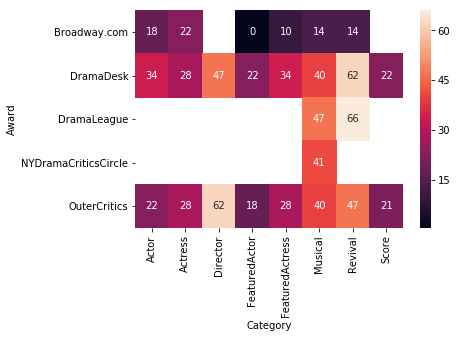

In [217]:
award_points = np.square(pretonys.pivot_table(index='Award',columns='Category',values='Tony',aggfunc=np.nanmean)) *  100


display(award_points)
sns.heatmap(award_points,annot=True,fmt='.0f')

In [396]:
def predict_category(category, pretonys, tony):
    won_points = pretonys.loc[(pretonys.Year==2019) & (pretonys.Won==1) & (pretonys.Category==category),:].merge(award_points, left_on='Award',right_index=True).loc[:,['Award','Nominee',category]]

    won_summary = won_points.groupby('Nominee').sum().sort_values(category,ascending=False)
    nominated_points = pretonys.loc[(pretonys.Year==2019) & 
                                    (pretonys.Won==0) & 
                                    (pretonys.Category==category),:].merge(award_points, 
                                                                           left_on='Award',
                                                                           right_index=True).loc[:,['Award','Nominee',category]]

    nominated_points.loc[:,category] = 0.25 * nominated_points.loc[:,category]
    nominated_summary = nominated_points.groupby('Nominee').sum().sort_values(category,ascending=False)
    overall_points = won_summary.merge(nominated_summary,how='outer',left_index=True,right_index=True).fillna(0).sum(axis=1)
    tony_predictions = tony.loc[(tony.Category==category) & (tony.Year==2019),['Nominee']].merge(pd.DataFrame(overall_points),how='left',left_on='Nominee',right_index=True)
    tony_predictions = tony_predictions.fillna(0).rename(columns={'Nominee':category,0:'Points'}).sort_values('Points',ascending=False)

    return tony_predictions

def generate_points_grid(category, pretonys, tony):
    won_points = pretonys.loc[(pretonys.Year==2019) & (pretonys.Won==1) & (pretonys.Category==category),:].merge(award_points, left_on='Award',right_index=True).loc[:,['Award','Nominee',category]]

    won_summary = won_points.groupby('Nominee')
    nominated_points = pretonys.loc[(pretonys.Year==2019) & 
                                    (pretonys.Won==0) & 
                                    (pretonys.Category==category),:].merge(award_points, 
                                                                           left_on='Award',
                                                                           right_index=True).loc[:,['Award','Nominee',category]]

    nominated_points.loc[:,category] = 0.25 * nominated_points.loc[:,category]
    points_grid = won_points.pivot(index='Nominee',
                 columns='Award',
                 values=category).add(nominated_points.pivot(index='Nominee',
                                                              columns='Award',
                                                              values=category),fill_value=0)

    points_grid = tony.loc[(tony.Category==category) & (tony.Year==2019),['Nominee']].merge(points_grid,how='left',left_on='Nominee',right_index=True).fillna(0)

    points_grid = points_grid.set_index('Nominee')

    sorted_index = points_grid.sum(axis=1).sort_values().index.values

    return points_grid.loc[sorted_index]

def plot_points_grid(category, pretonys, tony):
    points_grid = generate_points_grid(category, pretonys, tony)
    points_grid.plot(kind='barh', stacked=True)

def show_award_history(category, pretonys,tony):
    award_history = pretonys.loc[(pretonys.Category==category) & (pretonys.Won==1),:].pivot(index='Year',columns='Award',values='Nominee')
    award_history.loc[range(2000,2019),'Tony'] = tony.loc[(tony.Category==category) & (tony.Won==1),'Nominee'].values
    won_tony = pretonys.loc[(pretonys.Category==category) & (pretonys.Won==1),:].pivot(index='Year',columns='Award',values='Tony')
    won_tony.loc[:,'Tony'] = 1
    won_tony.iloc[-1,:] = 0
    labels = award_history.fillna('').values
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            labels[i,j] = labels[i,j].decode('unicode_escape').encode('ascii','ignore')
    plt.figure(figsize=(15,10))
    sns.heatmap(won_tony.values,annot=labels,fmt='s')
    plt.xticks(np.arange(labels.shape[1])+0.5,award_history.columns)
    x = plt.yticks(np.arange(labels.shape[0]),award_history.index)

## Best Original Musical

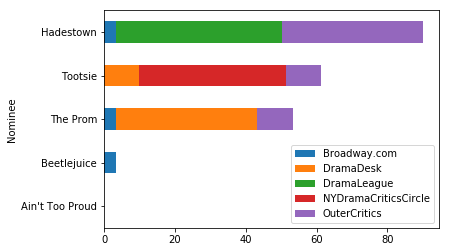

In [404]:
plot_points_grid('Musical',pretonys,tony)

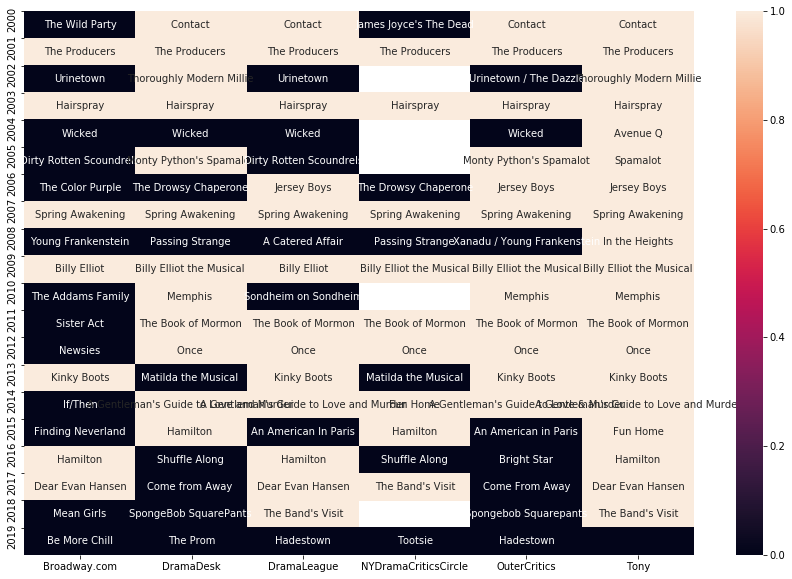

In [265]:
show_award_history('Musical', pretonys,tony)

## Best Revival

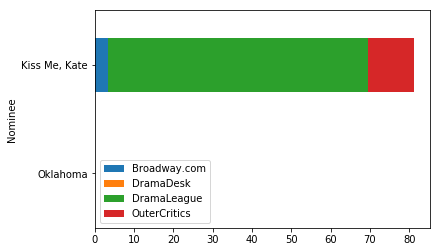

In [407]:
plot_points_grid('Revival',pretonys,tony)

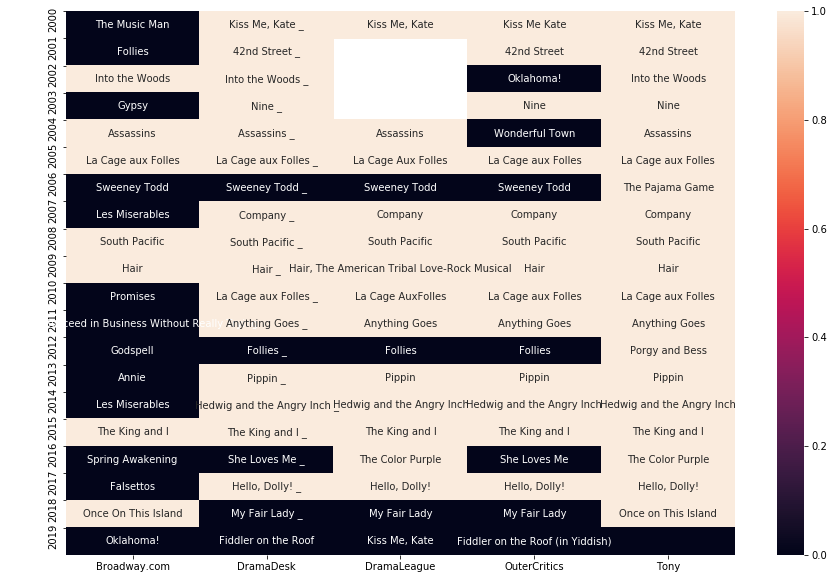

In [406]:
show_award_history('Revival', pretonys,tony)

## Best Director



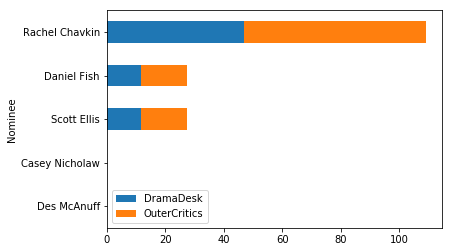

In [408]:
plot_points_grid('Director',pretonys,tony)

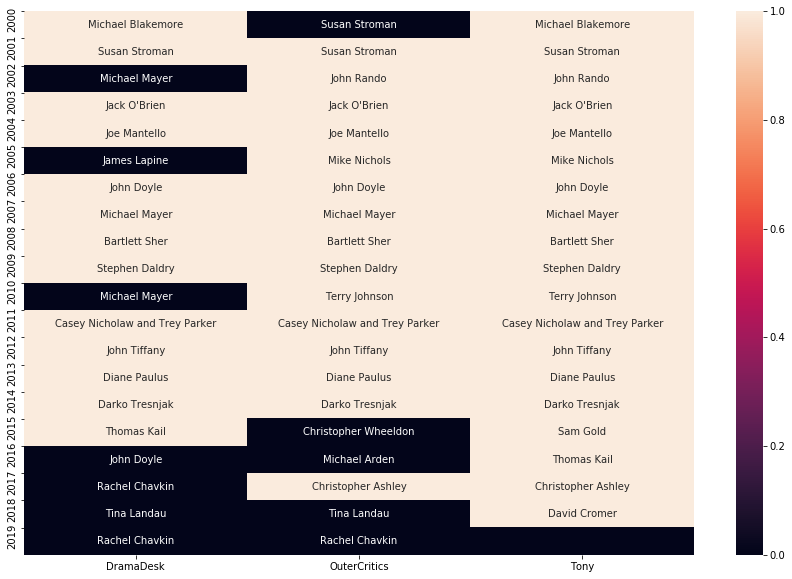

In [325]:
show_award_history('Director', pretonys,tony)

## Best Original Score

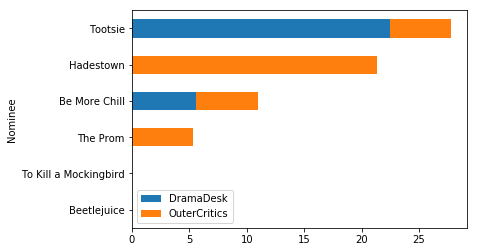

In [409]:
plot_points_grid('Score',pretonys,tony)

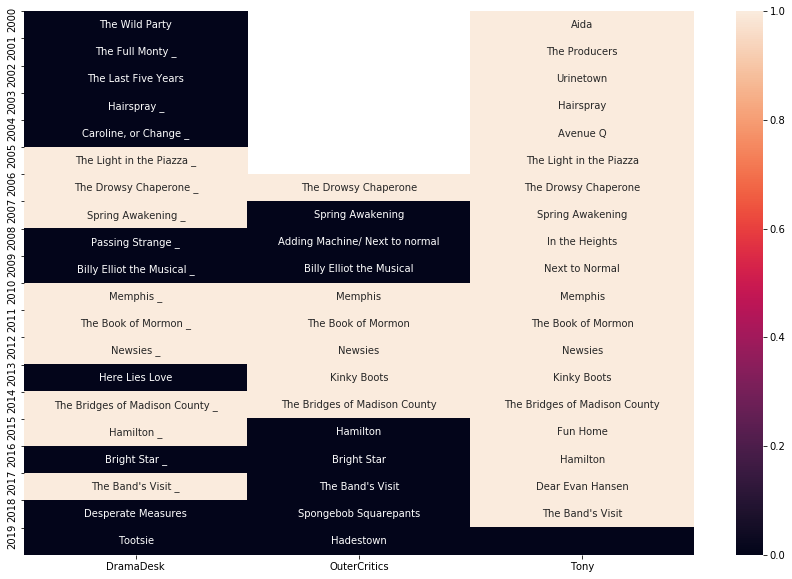

In [314]:
show_award_history('Score', pretonys,tony)

## Best Actor

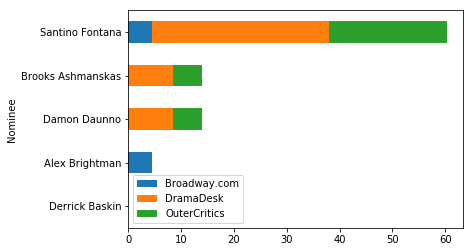

In [410]:
plot_points_grid('Actor',pretonys,tony)

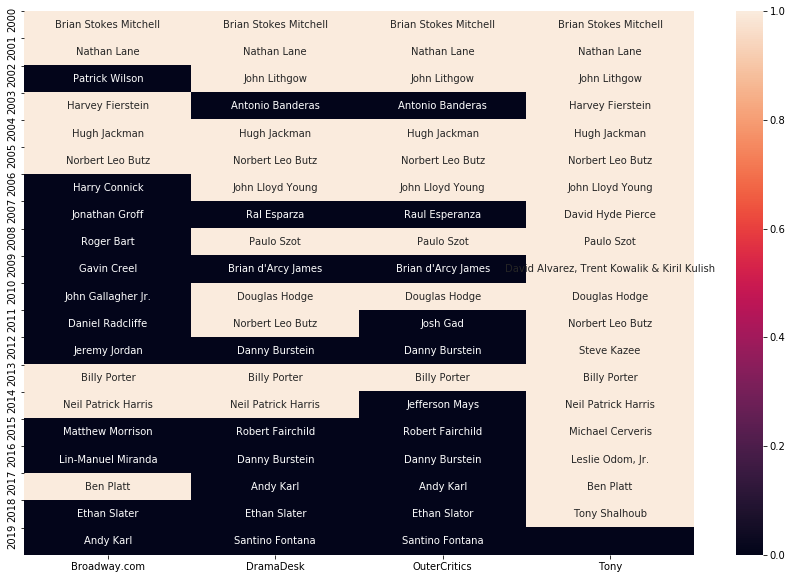

In [326]:
show_award_history('Actor', pretonys,tony)

# Best Actress

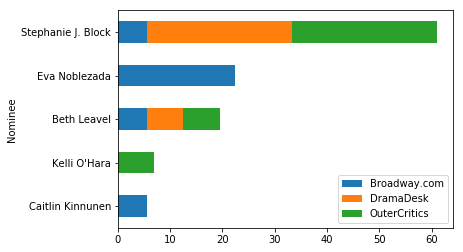

In [411]:
plot_points_grid('Actress',pretonys,tony)

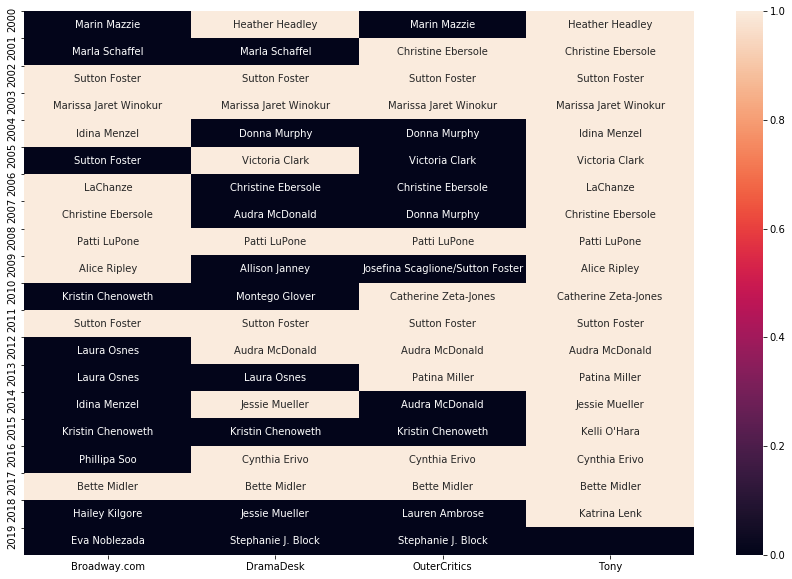

In [266]:
show_award_history('Actress', pretonys,tony)

# Best Featured Actor

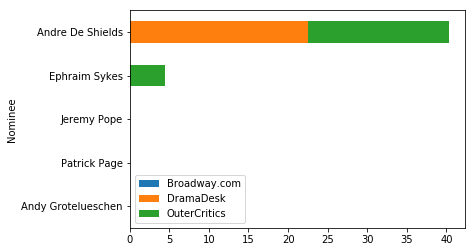

In [413]:
plot_points_grid('FeaturedActor',pretonys,tony)

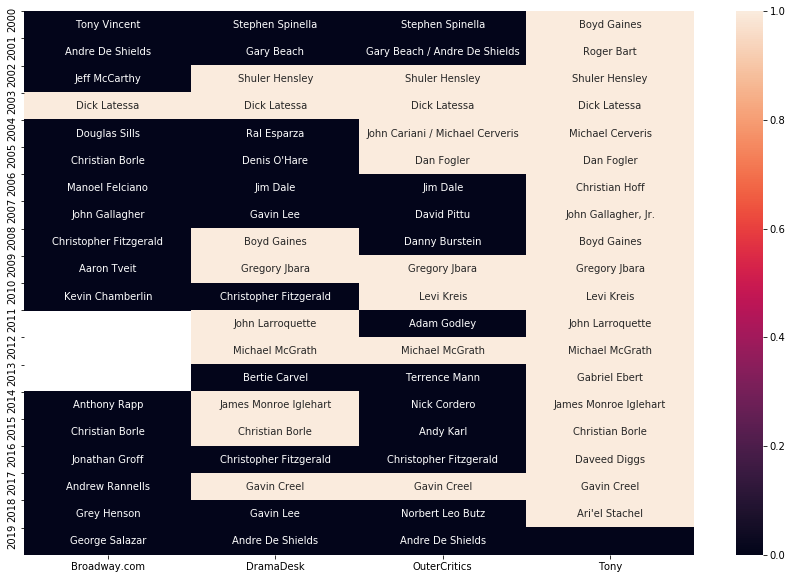

In [294]:
show_award_history('FeaturedActor', pretonys,tony)

# Best Featured Actress

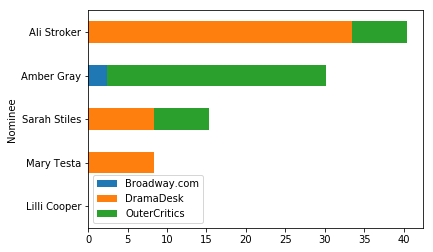

In [414]:
plot_points_grid('FeaturedActress',pretonys,tony)

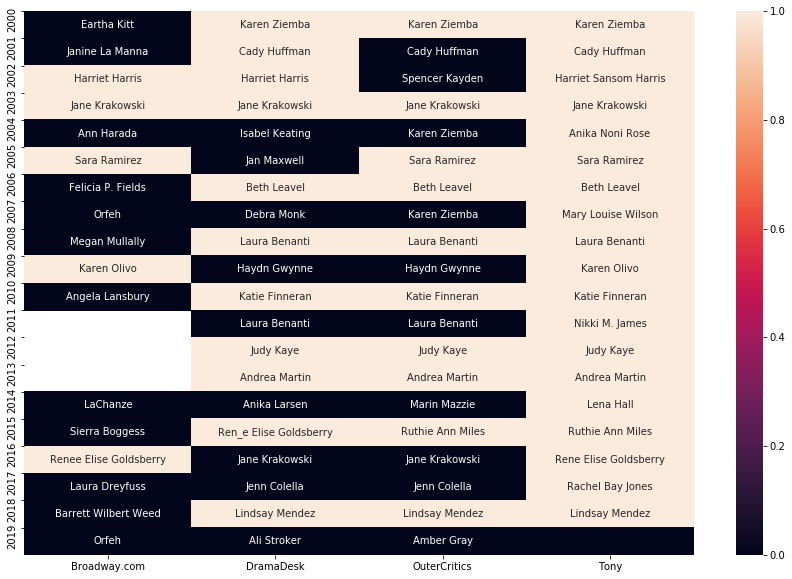

In [278]:
show_award_history('FeaturedActress', pretonys,tony)